### Investigating ghost coherence

In [90]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [91]:
import itertools
import os

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from frites.conn.conn_spec import conn_spec
from frites.conn.conn_tf import _tf_decomp
from frites.utils import parallel_func
from scipy.signal import find_peaks
from tqdm import tqdm

from GDa.session import session, session_info
from GDa.signal.surrogates import trial_swap_surrogates
from GDa.util import _extract_roi, create_stages_time_grid

#### Spectral analysis parameters

In [92]:
# Smoothing windows
sm_times = 0.3  # In seconds
sm_freqs = 1
sm_kernel = "square"

# Defining parameters
decim = 20  # Downsampling factor
mode = "multitaper"  # Wheter to use Morlet or Multitaper

n_freqs = 80  # How many frequencies to use
freqs = np.linspace(3, 75, n_freqs)  # Frequency array
n_cycles = freqs / 4  # Number of cycles
mt_bandwidth = None


def return_evt_dt(align_at):
    """Return the window in which the data will be loaded
    depending on the alignment"""
    assert align_at in ["cue", "match"]
    if align_at == "cue":
        return [-0.65, 3.00]
    else:
        return [-2.2, 0.65]

#### Loading data

In [93]:
# Instantiate class
ses = session(
    raw_path=os.path.expanduser("~/funcog/gda/GrayLab/"),
    monkey="lucy",
    date="141024",
    session=1,
    slvr_msmod=False,
    align_to="cue",
    evt_dt=[-0.65, 3.00],
)

# Read data from .mat files
ses.read_from_mat()

# Filtering by trials
data = ses.filter_trials(trial_type=[1], behavioral_response=[1])
# ROIs with channels
rois = [
    f"{roi} ({channel})" for roi, channel in zip(data.roi.data, data.channels_labels)
]
data = data.assign_coords({"roi": rois})

In [94]:
#### Surrogate data
n_surr = 1
data_surr = []
for i in range(n_surr):
    data_surr += [trial_swap_surrogates(data, seed=i + 500, verbose=False)]

In [95]:
band = slice(26, 43)

In [96]:
w = _tf_decomp(
    data,
    data.attrs["fsample"],
    freqs,
    mode=mode,
    n_cycles=n_cycles,
    mt_bandwidth=None,
    decim=decim,
    kw_cwt={},
    kw_mt={},
    n_jobs=20,
)

w = xr.DataArray(
    (w * np.conj(w)).real,
    name="power",
    dims=("trials", "roi", "freqs", "times"),
    coords=(data.trials.values, data.roi.values, freqs, data.time.values[::decim]),
)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   55.1s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:  1.2min remaining:    2.9s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:  1.2min finished


In [97]:
w = w.assign_coords({"roi": rois})

### Channels with large beta power

- F2 (36)
- F1 (63, 69, 73, 83, 84, 92, 95, 105)
- a3 (64, 65, 66, 106, 107)

In [98]:
channels = np.array([36, 63, 69, 73, 83, 84, 92, 95, 105, 64, 65, 66, 106, 107])
idx = [(ch in channels) for ch in data.channels_labels]

#### Trial-averaged spectogram

In [99]:
# Select ROIs
w_sel = w.isel(roi=idx)

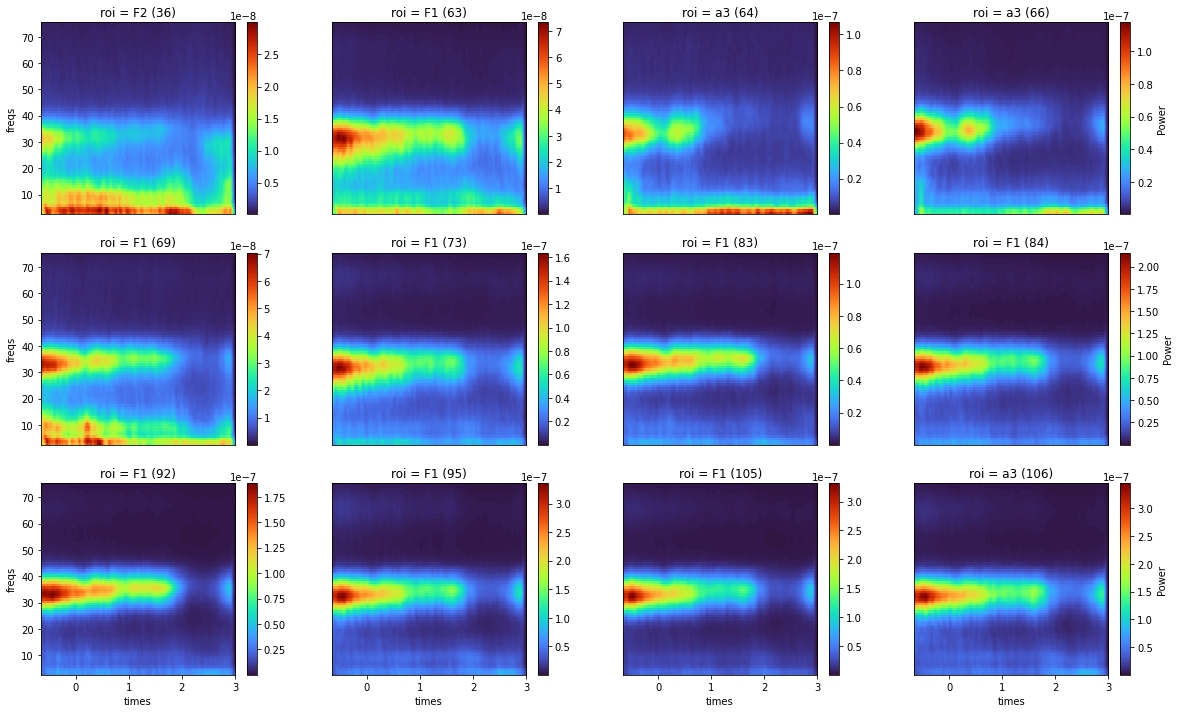

In [100]:
# Get number of ROIs
n_rois = w_sel.sizes["roi"]

out = w_sel.mean("trials")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    plt.subplot(3, 4, i + 1)
    cbar_kwargs = {"label": ""}
    if not (i + 1) % 4:
        cbar_kwargs = {"label": "Power"}
    out.isel(roi=i).plot.imshow(
        x="times", y="freqs", cmap="turbo", cbar_kwargs=cbar_kwargs
    )
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])

#### Time-averaged single trial power

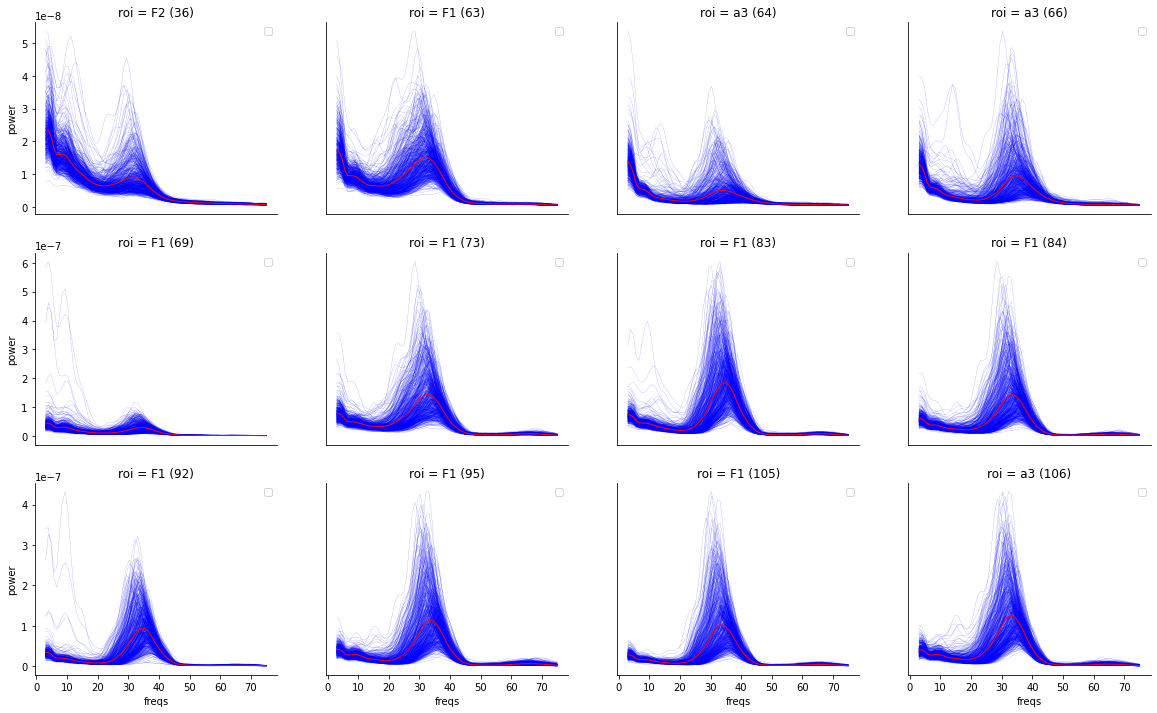

In [101]:
out = w_sel.mean("times")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 4, i + 1)
    out.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

#### Band-specific power time-series at single trial

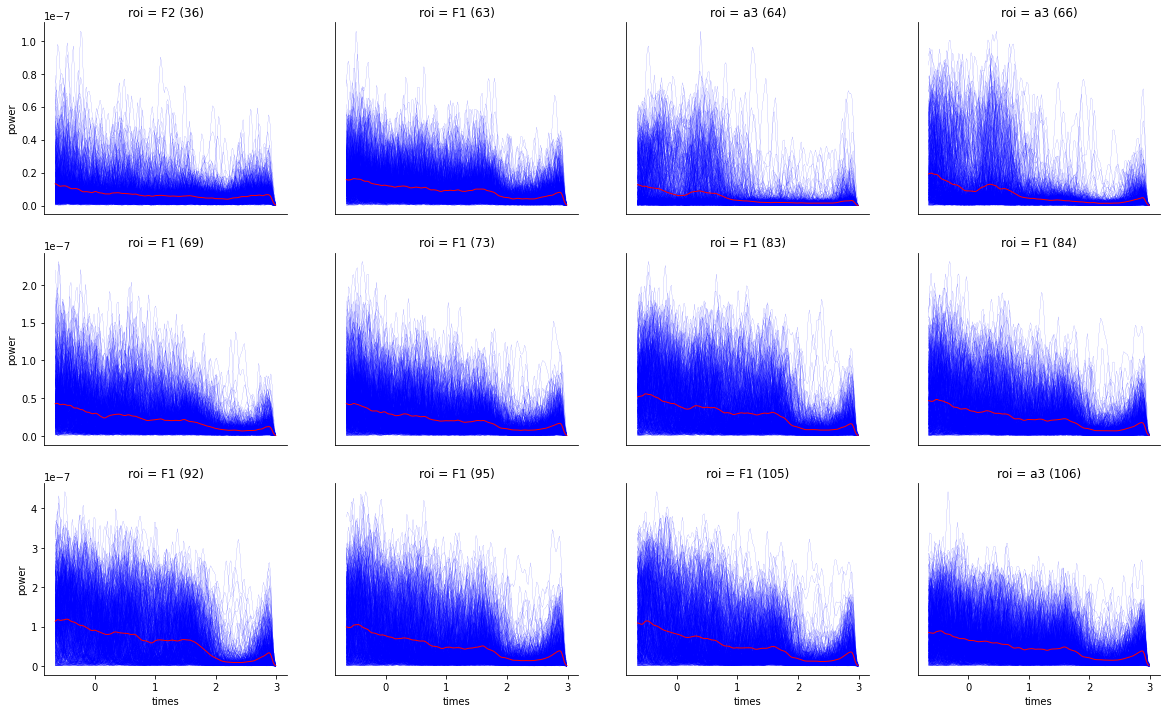

In [102]:
out = w_sel.sel(freqs=band).mean("freqs")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 4, i + 1)
    out.isel(roi=i).plot(x="times", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="times", hue="trials", lw=1, c="r")
    ax.get_legend().remove()
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

### Ghost-coherence with V1 (236)

- 36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117

#### Trial-averaged spectogram

In [103]:
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117, 236])
idx = [(ch in channels) for ch in data.channels_labels]

In [104]:
w_sel = w.isel(roi=idx)

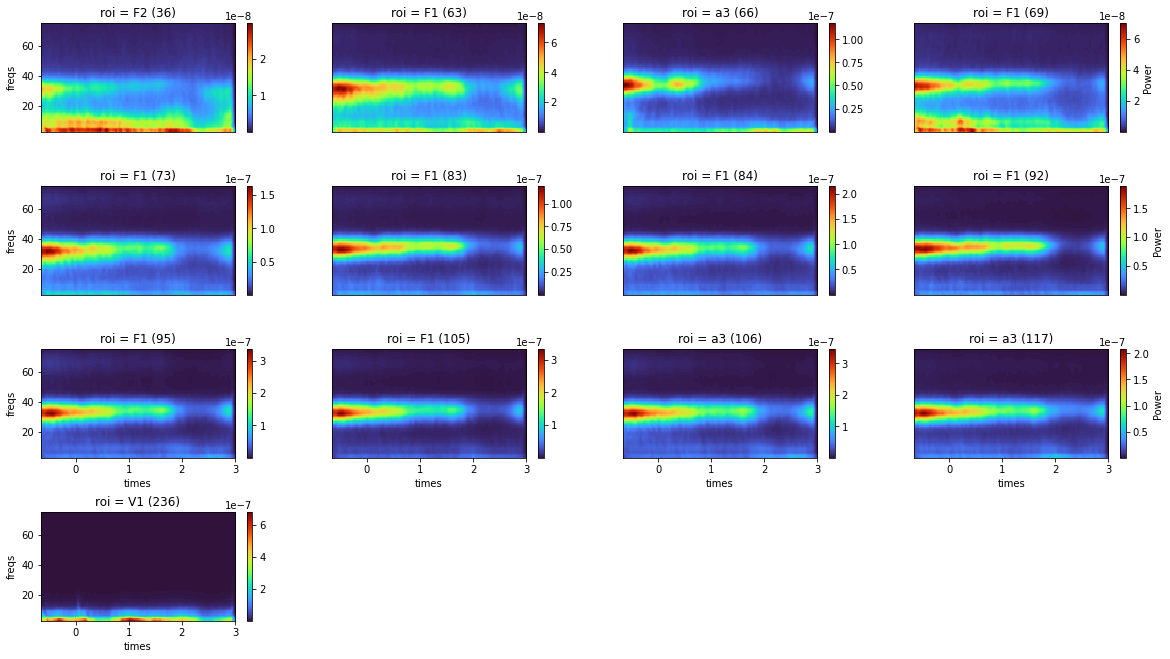

In [105]:
# Get number of ROIs
n_rois = w_sel.sizes["roi"]

out = w_sel.mean("trials")

plt.figure(figsize=(20, 14))
for i in range(n_rois):
    plt.subplot(5, 4, i + 1)
    cbar_kwargs = {"label": ""}
    if not (i + 1) % 4:
        cbar_kwargs = {"label": "Power"}
    out.isel(roi=i).plot.imshow(
        x="times", y="freqs", cmap="turbo", cbar_kwargs=cbar_kwargs
    )
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
plt.subplots_adjust(hspace=0.5)

#### Time-averaged single trial power

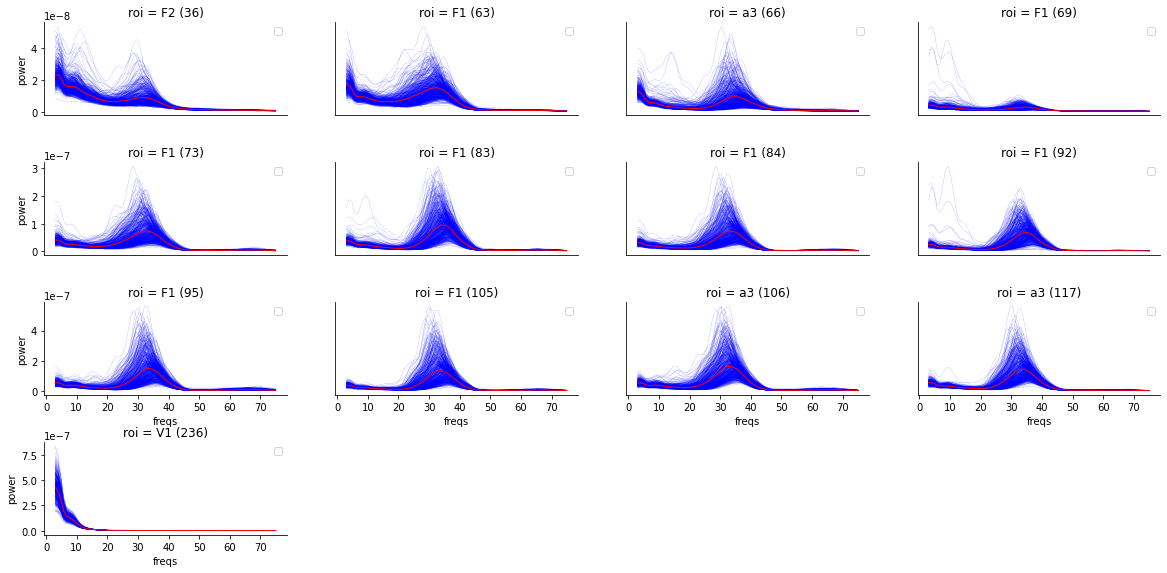

In [106]:
out = w_sel.mean("times")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(5, 4, i + 1)
    out.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
plt.subplots_adjust(hspace=0.5)

#### Band-specific power time-series at single trial

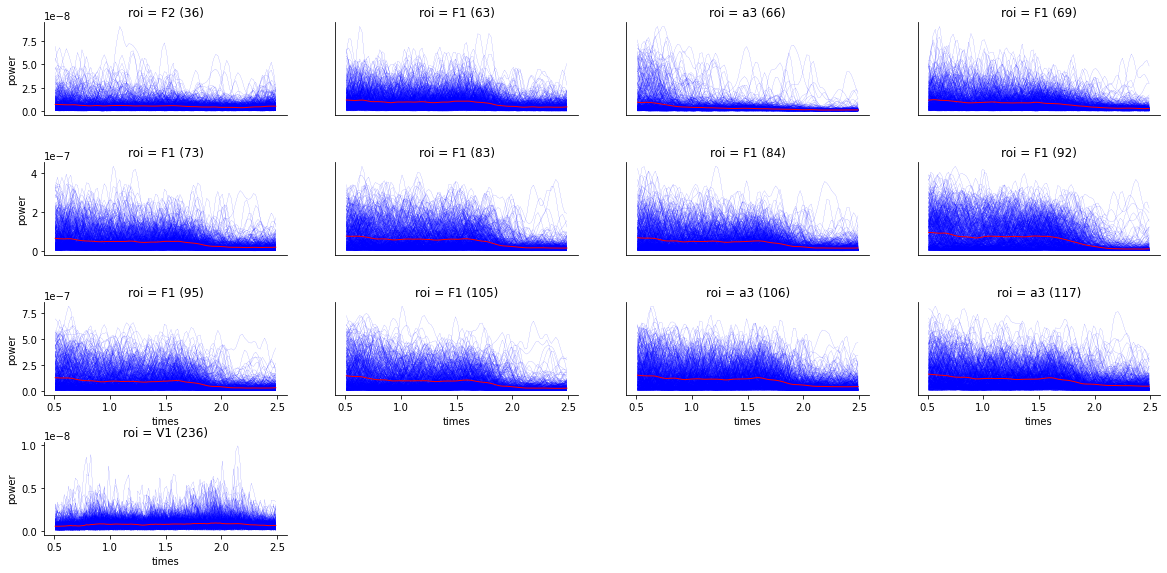

In [107]:
out = w_sel.sel(freqs=band).mean("freqs").sel(times=slice(0.5, 2.5))

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(5, 4, i + 1)
    out.isel(roi=i).plot(x="times", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="times", hue="trials", lw=1, c="r")
    ax.get_legend().remove()
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
plt.subplots_adjust(hspace=0.5)

### Computing coherence with V1 (236)

In [108]:
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117])
channel_v1 = np.array([236] * len(channels))

idx_s, idx_t = [], []

for ch in channels:
    if ch in data.channels_labels:
        idx_s.append(np.where(ch == data.channels_labels)[0][0])


for ch in channel_v1:
    if ch in data.channels_labels:
        idx_t.append(np.where(ch == data.channels_labels)[0][0])

In [109]:
pairs = np.vstack((idx_s, idx_t)).T

In [110]:
pairs = np.vstack((pairs, [27, 29]))

In [111]:
kw = dict(
    freqs=freqs,
    times="time",
    roi="roi",
    foi=None,
    n_jobs=20,
    pairs=pairs,
    sfreq=ses.data.attrs["fsample"],
    mode=mode,
    n_cycles=n_cycles,
    decim=decim,
    metric="coh",
    sm_times=sm_times,
    sm_freqs=sm_freqs,
    sm_kernel=sm_kernel,
    block_size=2,
)

# compute the coherence
coh = conn_spec(data, **kw).astype(np.float32, keep_attrs=True)

Defining links (n_roi=78; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Coherence (n_pairs=13, n_freqs=80, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   26.3s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   34.7s remaining:    1.4s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   35.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...290 : 0/13 [00:00<?,       ?it/s]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   29.1s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   37.5s remaining:    1.5s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   38.6s finished


  0%|          | Estimating pairwise Coherence for trials 291...581 : 0/13 [00:00<?,       ?it/s]

In [23]:
#### Surrogate data
data_surr = trial_swap_surrogates(data, seed=123456, verbose=False)

In [24]:
# compute the coherence
coh_surr = conn_spec(data_surr, **kw).astype(np.float32, keep_attrs=True)

Defining links (n_roi=78; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing pairwise Coherence (n_pairs=13, n_freqs=80, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   29.4s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   37.8s remaining:    1.5s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   38.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...290 : 0/13 [00:00<?,       ?it/s]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   32.2s
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:   41.5s remaining:    1.7s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:   42.3s finished


  0%|          | Estimating pairwise Coherence for trials 291...581 : 0/13 [00:00<?,       ?it/s]

(100.0, 100000.0)

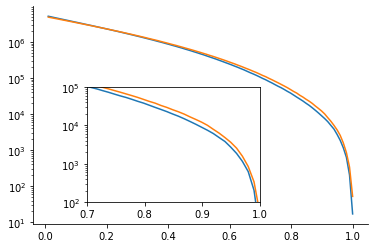

In [25]:
c, x = np.histogram(coh_surr.data.flatten(), np.linspace(0, 1, 100))
c1, x1 = np.histogram(coh.data.flatten(), np.linspace(0, 1, 100))

fig, ax1 = plt.subplots()

left, bottom, width, height = [0.25, 0.2, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.semilogy(x[1:], c)
ax1.semilogy(x1[1:], c1)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)

ax2.semilogy(x[1:], c)
ax2.semilogy(x1[1:], c1)
plt.xlim([0.7, 1])
plt.ylim([1e2, 1e5])

In [26]:
coh = np.clip(coh - coh_surr.quantile(0.95, "trials"), 0, np.inf)

In [27]:
coh_static = coh.sel(times=slice(-0.5, 0)).mean("times")

#### Trial-averaged time-frequency coherence

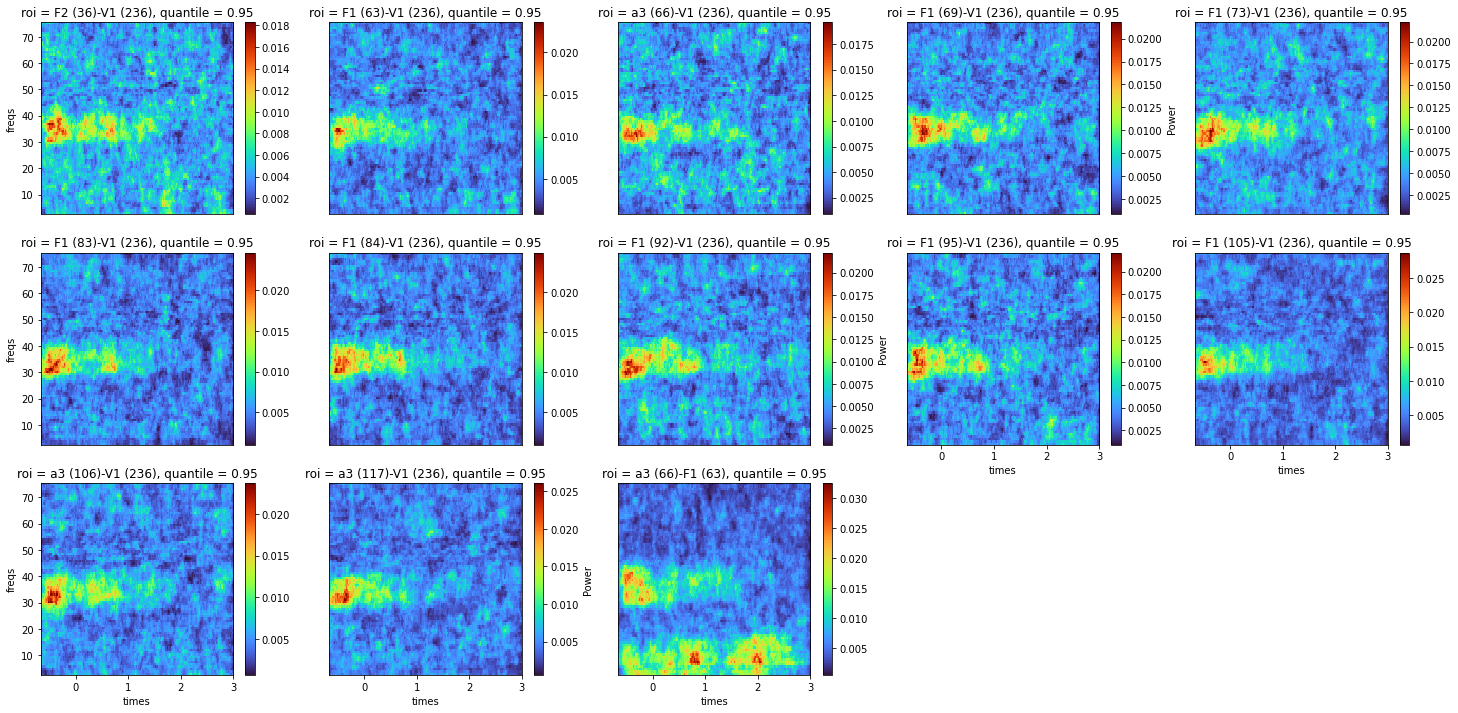

In [28]:
# Get number of ROIs
n_rois = coh.sizes["roi"]

out = coh.mean("trials")

plt.figure(figsize=(25, 12))
for i in range(n_rois):
    plt.subplot(3, 5, i + 1)
    cbar_kwargs = {"label": ""}
    if not (i + 1) % 4:
        cbar_kwargs = {"label": "Power"}
    out.isel(roi=i).plot.imshow(
        x="times", y="freqs", cmap="turbo", cbar_kwargs=cbar_kwargs
    )
    if i not in [0, 5, 10]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])

#### Time-averaged single trial coherence

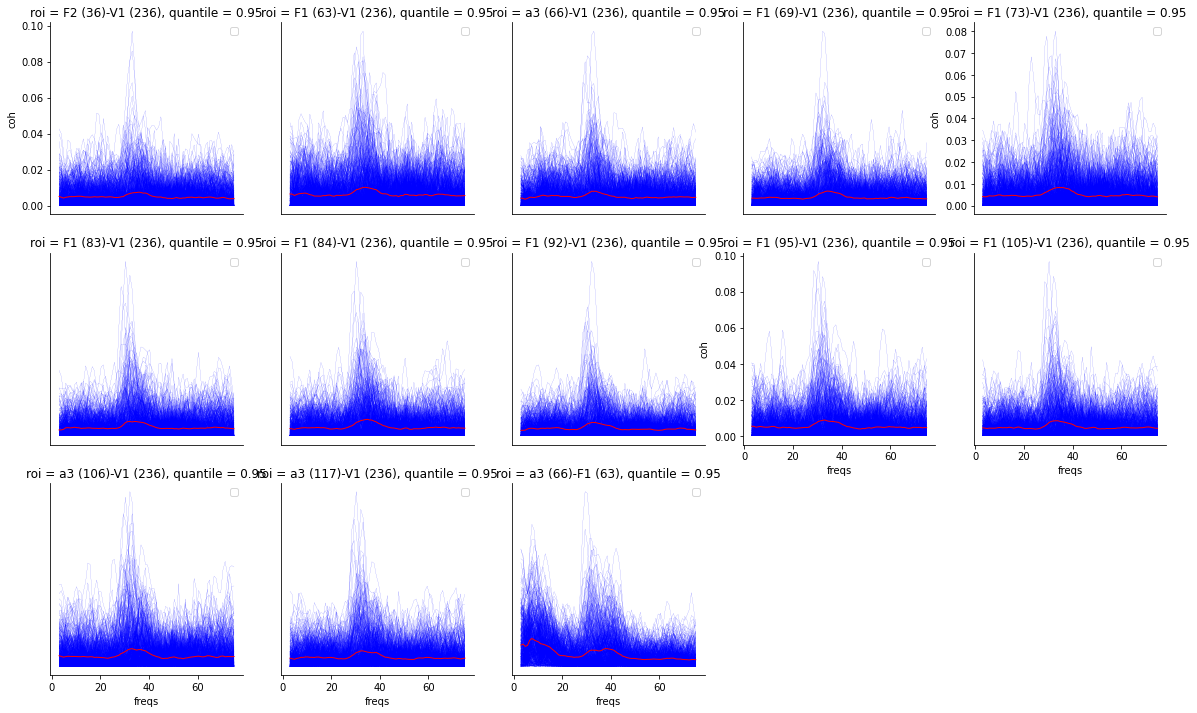

In [29]:
out = coh.mean("times")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 5, i + 1)
    out.isel(roi=i).plot(x="freqs", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

#### Band-specific coherence time-series at single trial

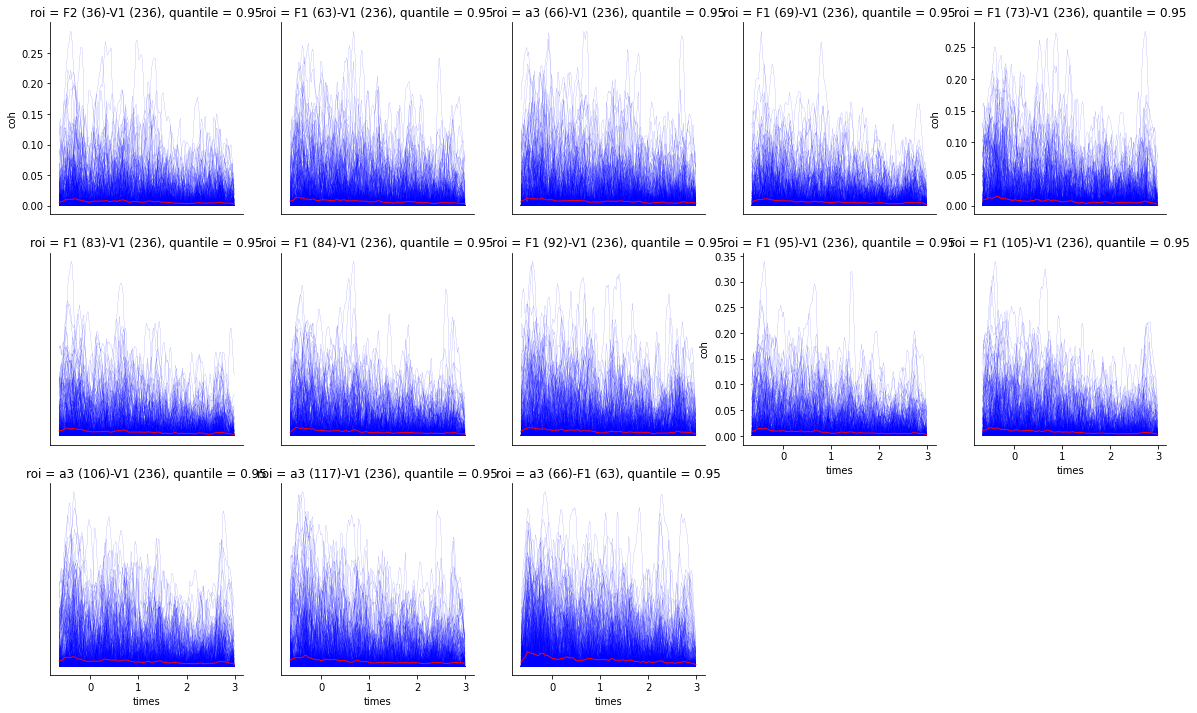

In [30]:
out = coh.sel(freqs=band).mean("freqs")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(3, 5, i + 1)
    out.isel(roi=i).plot(x="times", hue="trials", lw=0.1, c="b")
    out.mean("trials").isel(roi=i).plot(x="times", hue="trials", lw=1, c="r")
    ax.get_legend().remove()
    if i not in [0, 4, 8]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

### Finding peaks in the spectra and coherence

In [31]:
def detect_peaks(
    data, norm=None, kw_peaks={}, return_value=None, verbose=False, n_jobs=1
):

    assert isinstance(data, xr.DataArray)
    np.testing.assert_array_equal(data.dims, ["trials", "roi", "freqs"])

    # Names of properties in kw_peaks
    p_names = ["".join(list(key)) for key in kw_peaks.keys()]

    if norm:
        assert norm in ["max", "area"]
        if norm == "max":
            norm_values = data.max("freqs")
        else:
            norm_values = data.integrate("freqs")
        data = data / norm_values

    n_trials, n_rois = data.sizes["trials"], data.sizes["roi"]

    # Compute for each roi
    def _for_roi(i):
        peaks = np.zeros((n_trials, n_freqs))
        for t in range(n_trials):
            out, properties = find_peaks(data[t, i, :].data, **kw_peaks)
            if return_value is None:
                peaks[t, out] = 1
            else:
                peaks[t, out] = properties[return_value]
        return peaks

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_roi, n_jobs=n_jobs, verbose=verbose, total=n_rois
    )
    # Compute the single trial coherence
    peaks = parallel(p_fun(i) for i in range(n_rois))

    peaks = xr.DataArray(
        np.stack(peaks, 1), dims=data.dims, coords=data.coords, name="prominence"
    )

    return peaks

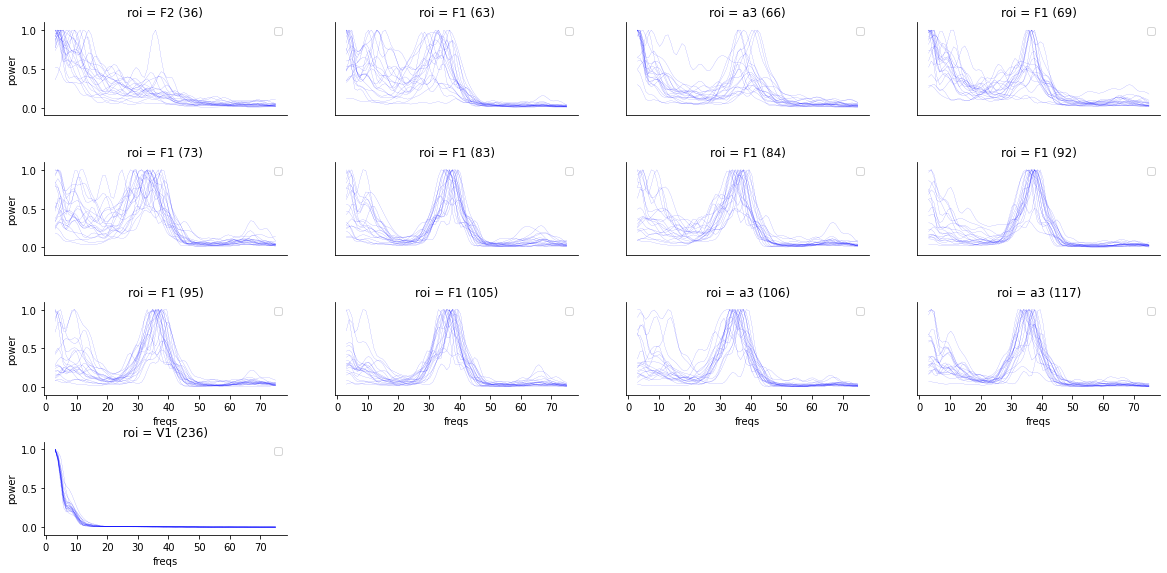

In [32]:
# Compute statical spectra
S = w_sel.sel(times=slice(-0.5, 0)).mean("times")
max_values = S.max("freqs")
S_norm = S / max_values
areas = S.roi.values

#  ROIs with channel numbers
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117, 236])
rois = [f"{area} ({channel})" for area, channel in zip(S.roi.values, channels)]

peaks = S.sel(freqs=band).max("freqs")

plt.figure(figsize=(20, 12))
for i in range(n_rois):
    ax = plt.subplot(5, 4, i + 1)
    S_norm.isel(roi=i, trials=slice(10, 30)).plot(
        x="freqs", hue="trials", lw=0.1, c="b"
    )
    # |S_norm.mean("trials").isel(roi=i).plot(x="freqs", hue="trials", lw=1, c="r")
    plt.legend([])
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    if i < 8:
        plt.xlabel("")
        plt.xticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.ylim([-0.1, 1.1])
plt.subplots_adjust(hspace=0.5)

#### Peak prominence distributions

In [33]:
prominences = detect_peaks(
    S, kw_peaks=dict(height=0.1, prominence=0), return_value="prominences", norm="max"
)

  0%|          |  : 0/13 [00:00<?,       ?it/s]

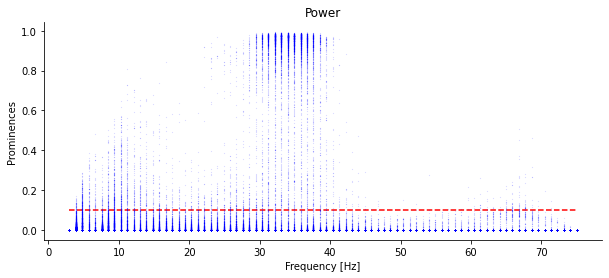

In [34]:
max_pro = prominences.max().data
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for f in range(prominences.sizes["freqs"]):
    # Get prominences for all trials and roi for this given frequency
    pro = prominences.isel(freqs=f).data.flatten()
    x = np.ones_like(pro) * prominences.freqs.data[f]
    plt.plot(x, pro, ".b", ms=0.1)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.hlines(0.1 * max_pro, freqs[0], freqs[-1], "r", ls="--")
plt.ylabel("Prominences")
plt.xlabel("Frequency [Hz]")
plt.title("Power");

In [35]:
p = detect_peaks(
    S,
    kw_peaks=dict(height=0.1, prominence=0.1 * max_pro),
    return_value=None,
    norm="max",
)

  0%|          |  : 0/13 [00:00<?,       ?it/s]

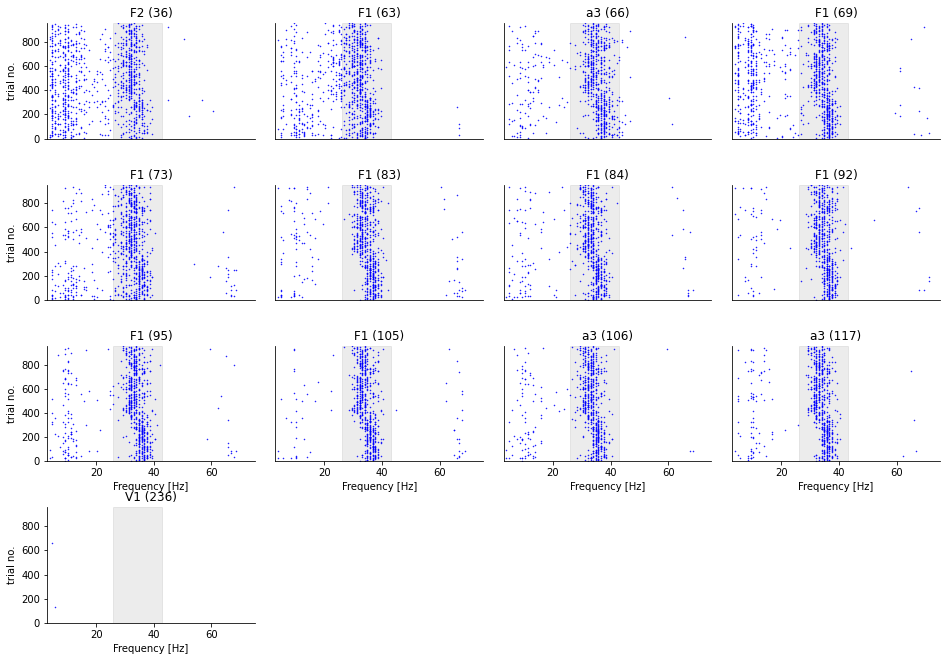

In [36]:
plt.figure(figsize=(16, 14))
for i in range(p.sizes["roi"]):
    ax = plt.subplot(5, 4, i + 1)
    for t in range(p.sizes["trials"]):
        idx = p.isel(roi=i, trials=t).values.astype(bool)
        f = p.freqs.data[idx]
        plt.plot(f, [p.trials.data[t]] * len(f), "ob", ms=0.5)
    plt.xlim(p.freqs.min(), p.freqs.max())
    plt.ylim(p.trials.min() - 1, p.trials.max() + 1)
    plt.axvspan(26, 43, alpha=0.15, color="gray")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.title(f"{p.roi.data[i]}")
    if i < 8:
        plt.xticks([])
        plt.xlabel("")
    else:
        plt.xlabel("Frequency [Hz]")
    if i not in [0, 4, 8, 12]:
        plt.ylabel("")
        plt.yticks([])
    else:
        plt.ylabel("trial no.")
plt.subplots_adjust(hspace=0.4, wspace=0.1)

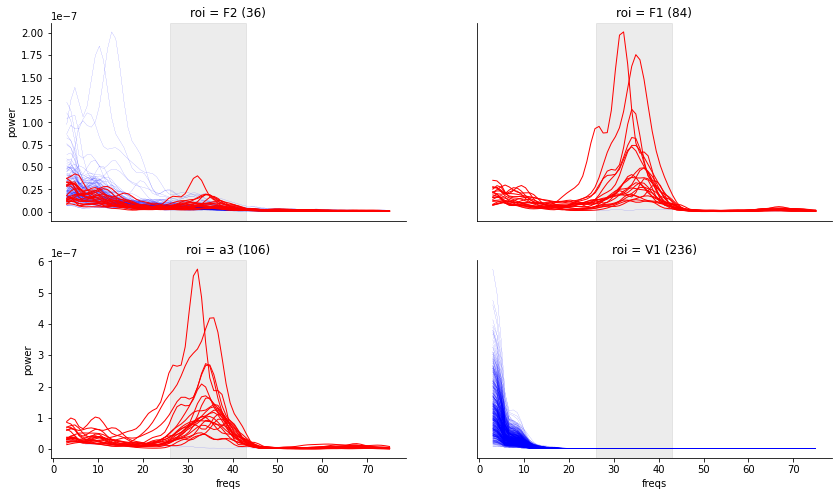

In [37]:
plt.figure(figsize=(14, 8))
for i, r in enumerate([0, 6, 10, 12]):
    ax = plt.subplot(2, 2, i + 1)

    # Index of trial that have a peak
    idx = p.isel(roi=r).sel(freqs=band).sum("freqs") > 0

    S.isel(roi=r, trials=np.logical_not(idx)).plot(
        x="freqs", hue="trials", lw=0.1, color="blue"
    )

    if np.sum(idx) > 0:
        S.isel(roi=r).isel(trials=idx).isel(trials=slice(0, 20)).plot(
            x="freqs", hue="trials", color="red", lw=1
        )

    ax.get_legend().remove()
    plt.axvspan(26, 43, alpha=0.15, color="gray")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    if i < 2:
        plt.xticks([])
        plt.xlabel("")
    if i % 2:
        plt.yticks([])
        plt.ylabel("")

#### Peak prominence distribution for coherence

In [38]:
p_coh = detect_peaks(
    coh_static,
    kw_peaks=dict(height=0.1, prominence=0),
    return_value="prominences",
    norm=None,
)

  0%|          |  : 0/13 [00:00<?,       ?it/s]

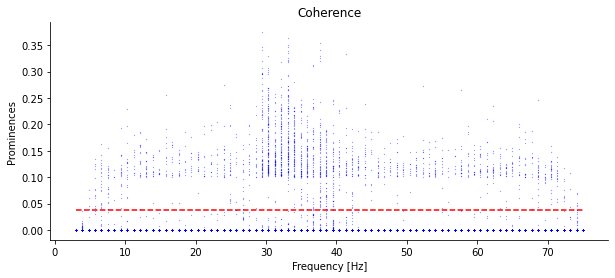

In [39]:
max_pro_coh = p_coh.max().data
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
for f in range(p_coh.sizes["freqs"]):
    # Get prominences for all trials and roi for this given frequency
    pro = p_coh.isel(freqs=f).data.flatten()
    x = np.ones_like(pro) * p_coh.freqs.data[f]
    plt.plot(x, pro, ".b", ms=0.3)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.hlines(0.1 * max_pro_coh, freqs[0], freqs[-1], "r", ls="--")
plt.ylabel("Prominences")
plt.xlabel("Frequency [Hz]")
plt.title("Coherence");

In [40]:
p_coh = detect_peaks(
    coh_static,
    kw_peaks=dict(height=0.1, prominence=0.1 * max_pro_coh),
    return_value=None,
    norm=None,
)

  0%|          |  : 0/13 [00:00<?,       ?it/s]

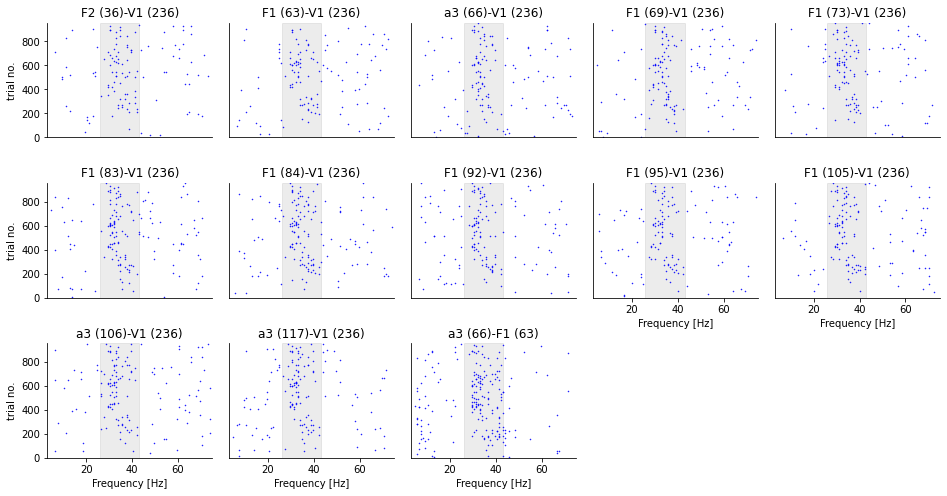

In [41]:
plt.figure(figsize=(16, 8))
for i in range(p_coh.sizes["roi"]):
    ax = plt.subplot(3, 5, i + 1)
    for t in range(p.sizes["trials"]):
        idx = p_coh.isel(roi=i, trials=t).values.astype(bool)
        f = p_coh.freqs.data[idx]
        plt.plot(f, [p_coh.trials.data[t]] * len(f), "ob", ms=0.5)
    plt.xlim(p_coh.freqs.min(), p.freqs.max())
    plt.ylim(p_coh.trials.min() - 1, p.trials.max() + 1)
    plt.axvspan(26, 43, alpha=0.15, color="gray")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.title(f"{p_coh.roi.data[i]}")
    if i < 8:
        plt.xticks([])
        plt.xlabel("")
    else:
        plt.xlabel("Frequency [Hz]")
    if i not in [0, 5, 10]:
        plt.ylabel("")
        plt.yticks([])
    else:
        plt.ylabel("trial no.")
plt.subplots_adjust(hspace=0.4, wspace=0.1)

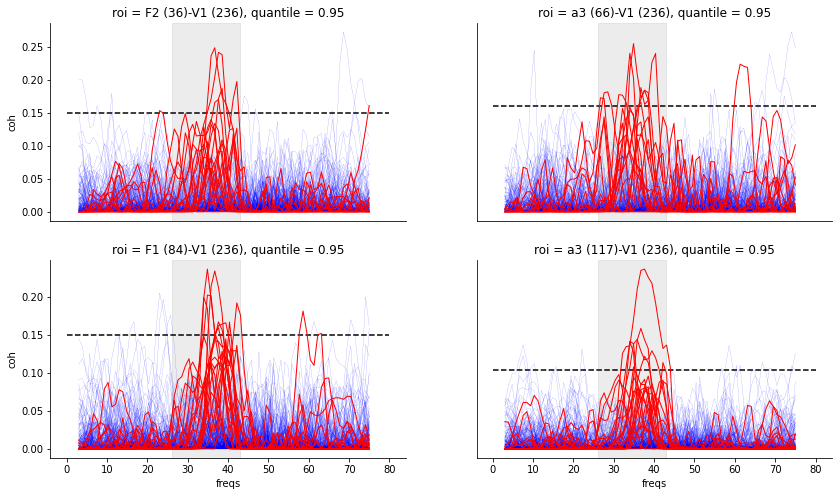

In [42]:
plt.figure(figsize=(14, 8))
for i, r in enumerate([0, 2, 6, 11]):
    ax = plt.subplot(2, 2, i + 1)

    # Index of trial that have a peak
    idx = p_coh.isel(roi=r).sel(freqs=band).sum("freqs") > 0

    coh_static.isel(roi=r, trials=np.logical_not(idx)).plot(
        x="freqs", hue="trials", lw=0.1, color="blue"
    )

    if np.sum(idx) > 0:
        coh_static.isel(roi=r).isel(trials=idx).isel(trials=slice(0, 20)).plot(
            x="freqs", hue="trials", color="red", lw=1
        )

    ax.get_legend().remove()
    plt.axvspan(26, 43, alpha=0.15, color="gray")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    if i < 2:
        plt.xticks([])
        plt.xlabel("")
    if i % 2:
        plt.yticks([])
        plt.ylabel("")
    plt.hlines(0.15, 0, coh_static.sizes["freqs"], color="black", ls="--")

|           | Power i | Power j | Coh ij |     Outcome    |
|:---------:|:-------:|:-------:|:------:|:--------------:|
| Has peak? |    T    |    T    |    T   |  True positive |
|           |    T    |    T    |    F   | False negative |
|           |    T    |    F    |    F   |  True negative |
|           |    F    |    T    |    T   | False positive |
|           |    F    |    F    |    T   | False positive |
|           |    F    |    F    |    F   |  True negative |

#### Checking for channel F2 and V1

In [43]:
bands = np.array([[0, 6], [6, 14], [14, 26], [26, 43], [43, 80]])

p_band = []
p_coh_band = []
for flow, fhigh in bands:
    p_band += [(p.sel(freqs=slice(flow, fhigh)).sum("freqs") > 0).astype(int)]
    p_coh_band += [(p_coh.sel(freqs=slice(flow, fhigh)).sum("freqs") > 0).astype(int)]

p_band = xr.concat(p_band, "freqs")
p_coh_band = xr.concat(p_coh_band, "freqs")

In [44]:
O1 = p_coh_band.isel(roi=6) * (
    p_band.isel(roi=6) + p_band.isel(roi=-1)
) + p_coh_band.isel(roi=6)
# O1 = O1.isel(trials=O1.sum("freqs") > 0)

O2 = p_coh_band.isel(roi=-1) * (
    p_band.isel(roi=1) + p_band.isel(roi=2)
) + p_coh_band.isel(roi=-1)
# O2 = O2.isel(trials=O2.sum("freqs") > 0)

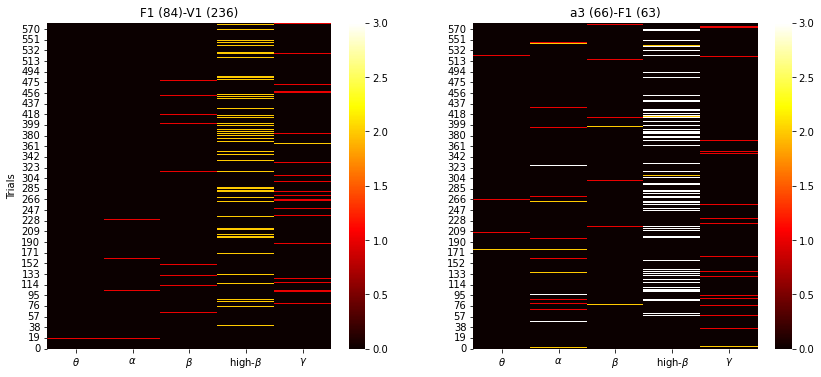

In [45]:
plt.figure(figsize=(14, 6))

ax = plt.subplot(1, 2, 1)
sns.heatmap(data=O1.T, cmap="hot", cbar=True, vmax=3)
ax.invert_yaxis()
plt.title(f"{O1.roi.data}")
plt.yticks(rotation=0)
plt.ylabel("Trials")
plt.xticks(
    np.arange(0.5, 5.5),
    [r"$\theta$", r"$\alpha$", r"$\beta$", r"high-$\beta$", r"$\gamma$"],
)

ax = plt.subplot(1, 2, 2)
sns.heatmap(data=O2.T, cmap="hot", cbar=True, vmax=3)
ax.invert_yaxis()
plt.title(f"{O2.roi.data}")
plt.yticks(rotation=0)
plt.ylabel("Trials")
plt.ylabel("")
plt.xticks(
    np.arange(0.5, 5.5),
    [r"$\theta$", r"$\alpha$", r"$\beta$", r"high-$\beta$", r"$\gamma$"],
);

### Overlap of beta and gamma bands

In [46]:
beta = slice(26, 43)
gamma = slice(43, 80)

In [47]:
w_beta = w.sel(freqs=beta).mean("freqs")
w_gamma = w.sel(freqs=gamma).mean("freqs")

In [48]:
z_beta = (w_beta - w_beta.mean("times")) / w_beta.std("times")
z_gamma = (w_gamma - w_gamma.mean("times")) / w_gamma.std("times")

cc = (z_beta * z_gamma).mean("times")

In [49]:
df = cc.to_dataframe(name="cc").reset_index()
df = df.sort_values("cc", ascending=False)

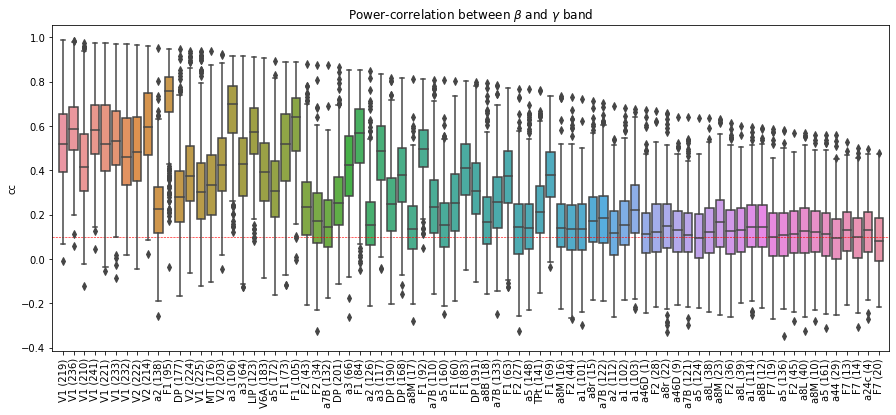

In [50]:
plt.figure(figsize=(15, 6))

sns.boxplot(x=df["roi"], y=df["cc"])
plt.xticks(rotation=90)
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.hlines(0.1, -1, cc.sizes["roi"], color="r", ls="--", lw=0.6)
plt.xlim(-1, cc.sizes["roi"])
plt.title(r"Power-correlation between $\beta$ and $\gamma$ band");

In [51]:
z_beta = (w_beta - w_beta.mean("times")) / w_beta.std("times")
z_gamma = (w_gamma - w_gamma.mean("times")) / w_gamma.std("times")

trials_shuffle = z_gamma.trials.data

CC = []

for i in tqdm(range(500)):

    np.random.shuffle(trials_shuffle)

    x1 = z_beta.sel(trials=trials_shuffle)

    np.random.shuffle(trials_shuffle)

    x2 = z_gamma.sel(trials=trials_shuffle)

    cc_surr = (x1 * x2).mean("times")

    CC += [cc_surr]

100%|██████████████████████████| 500/500 [01:01<00:00,  8.12it/s]


In [52]:
thr = xr.concat(CC, dim="surr").quantile(0.95, "surr")
thr = thr.to_dataframe("thr").reset_index()

In [53]:
mean = thr.groupby(["roi"]).mean("thr")
std = thr.groupby(["roi"])["thr"].std()

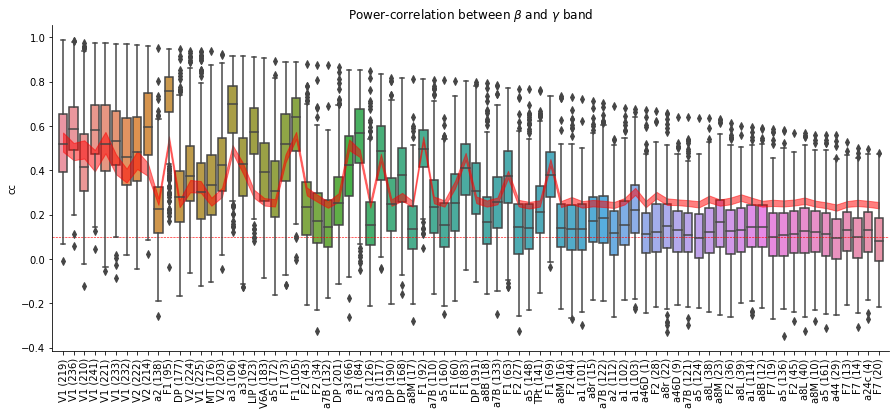

In [54]:
plt.figure(figsize=(15, 6))

ax = sns.boxplot(x=df["roi"], y=df["cc"])

rois = [t.get_text() for t in ax.get_xticklabels()]

mean = mean.reindex(index=rois).thr.values
std = std.reindex(index=rois).reset_index().thr.values

plt.fill_between(
    range(cc.sizes["roi"]),
    mean - std,
    mean + std,
    alpha=0.5,
    color="red",
)
plt.xticks(rotation=90)
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.hlines(0.1, -1, cc.sizes["roi"], color="r", ls="--", lw=0.6)
plt.xlim(-1, cc.sizes["roi"])
plt.title(r"Power-correlation between $\beta$ and $\gamma$ band");

#### Channels above chance level

In [55]:
z_beta = z_beta.assign_coords({"roi": cc.roi.data})
z_gamma = z_gamma.assign_coords({"roi": cc.roi.data})

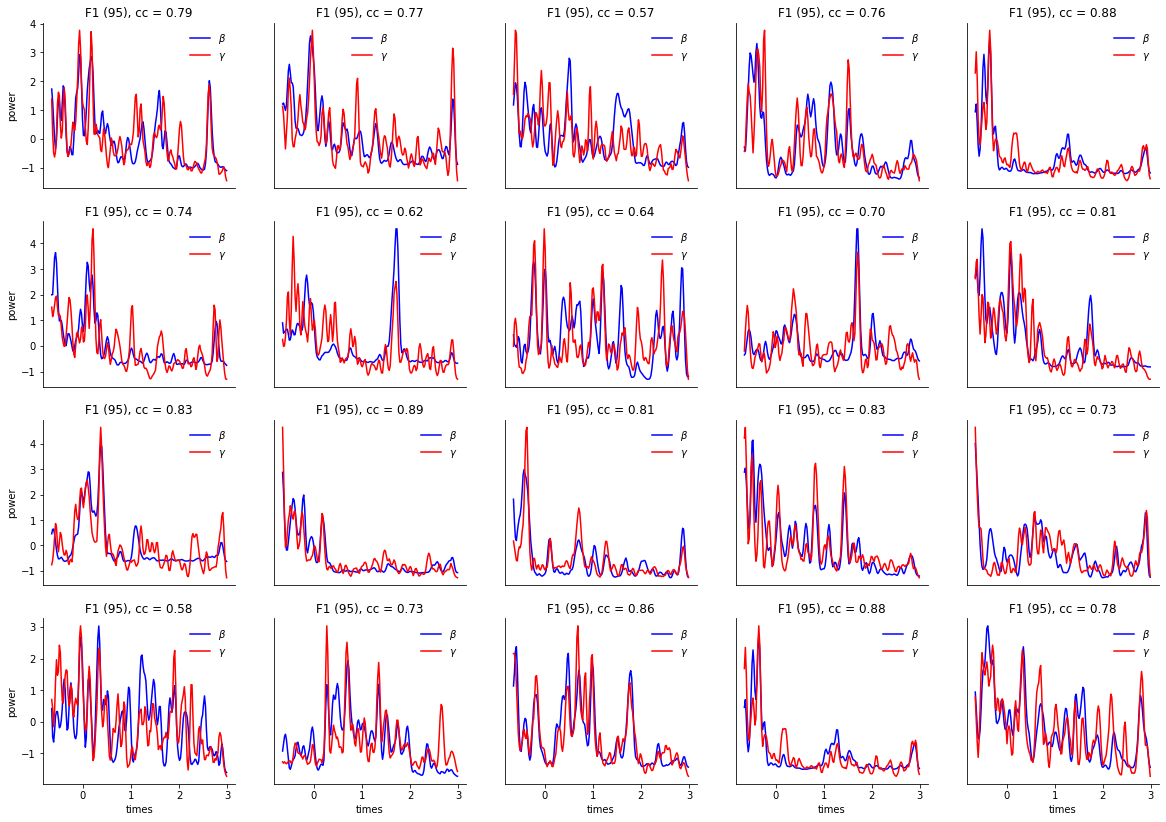

In [56]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "F1 (95)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

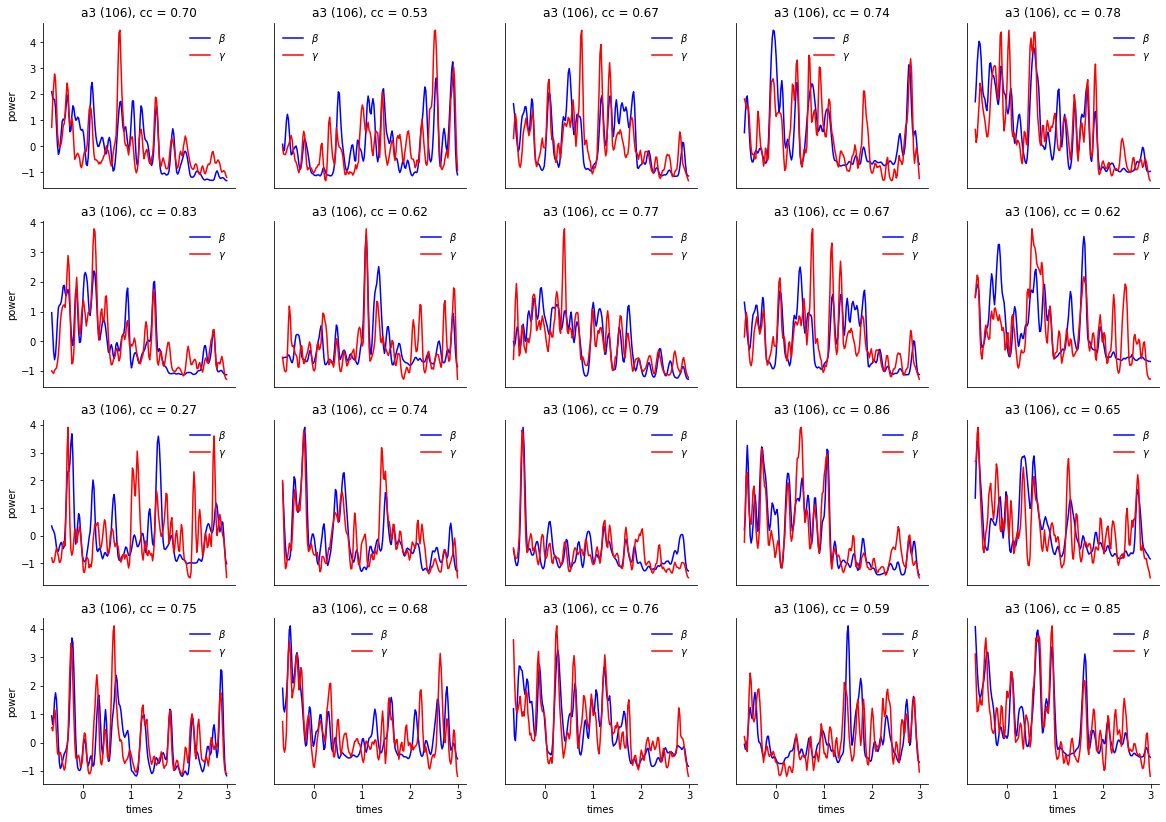

In [57]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "a3 (106)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

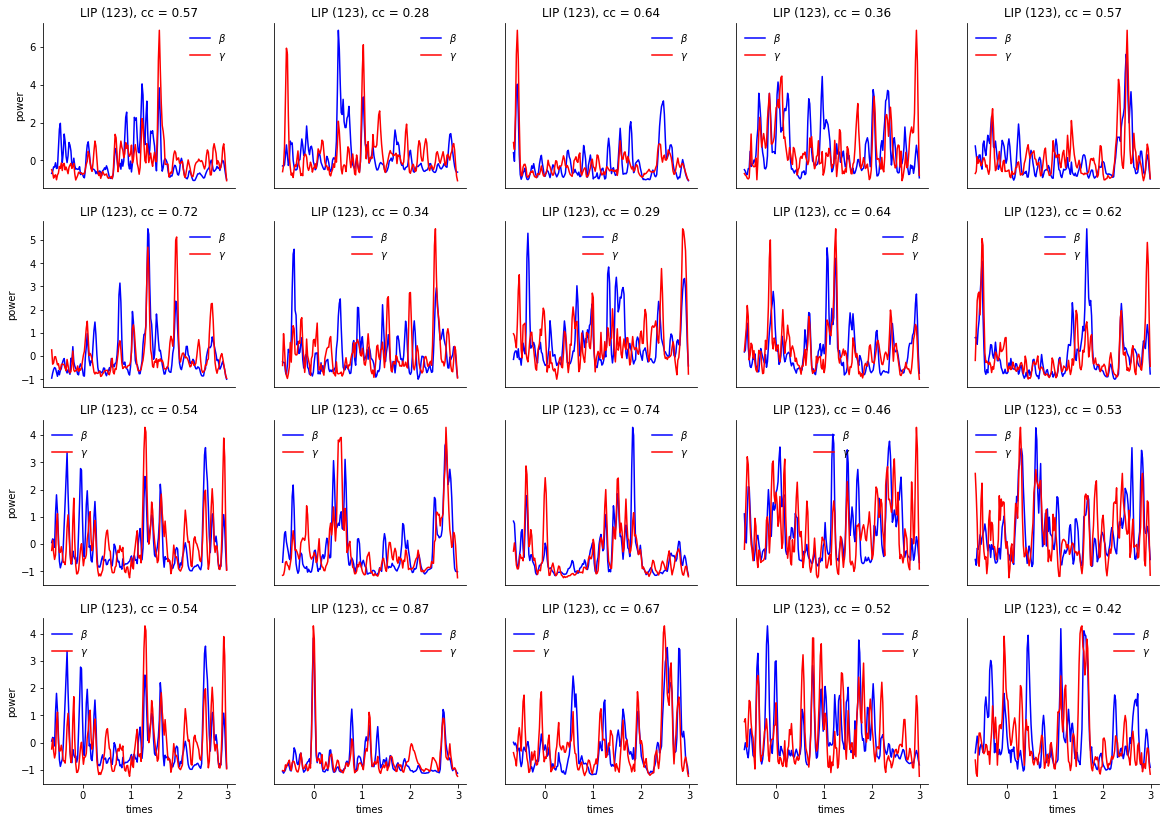

In [58]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "LIP (123)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

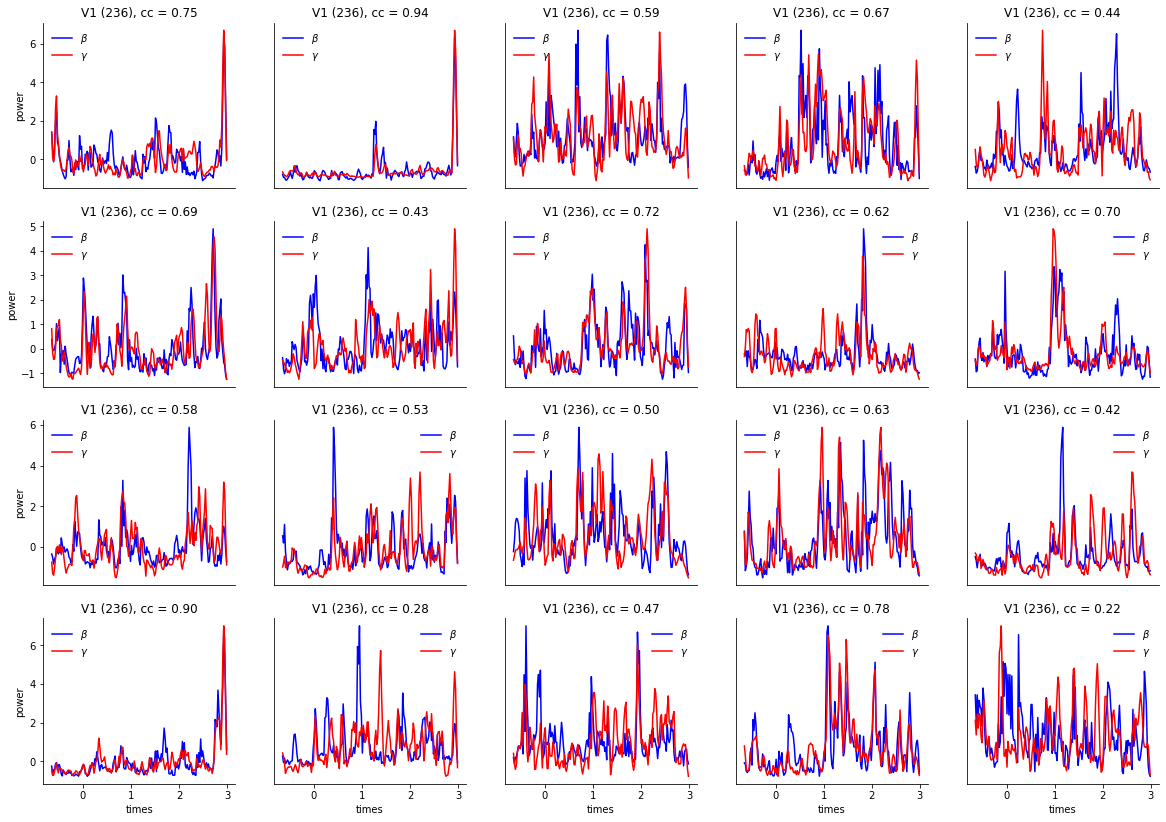

In [59]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "V1 (236)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

#### Channels bellow chance level

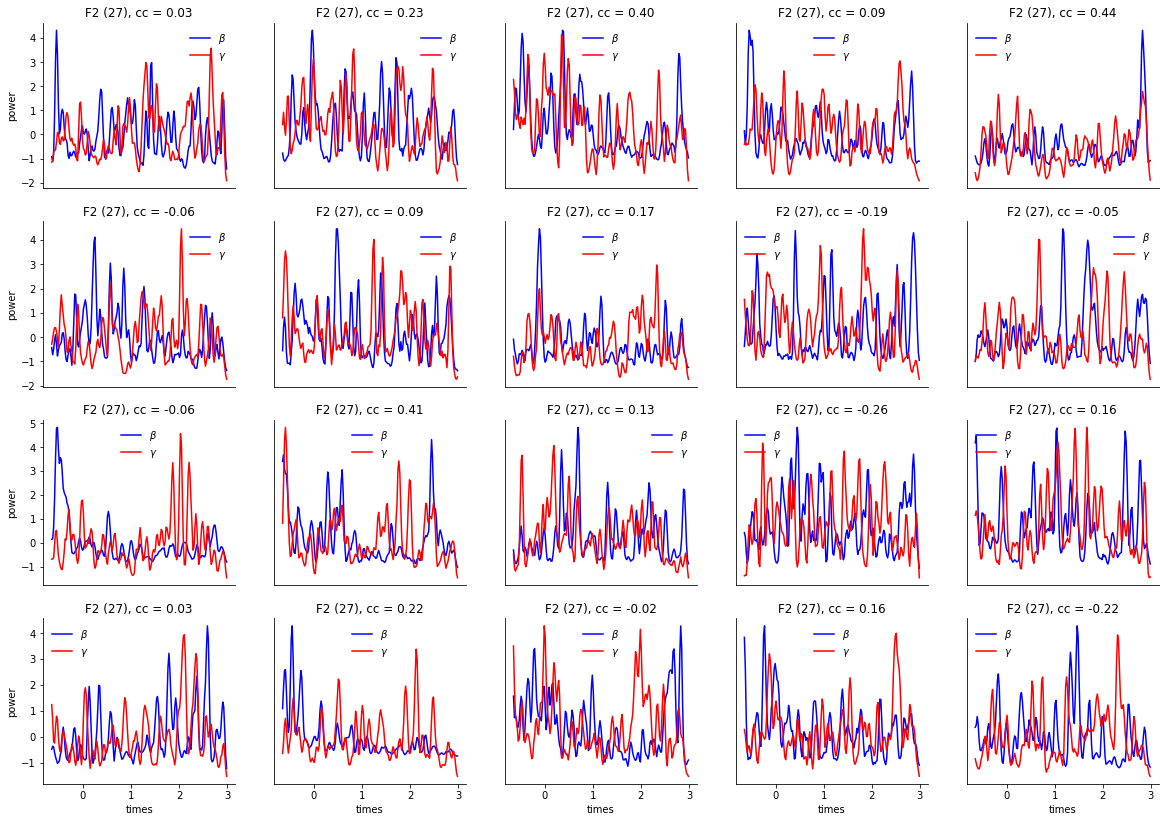

In [60]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "F2 (27)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

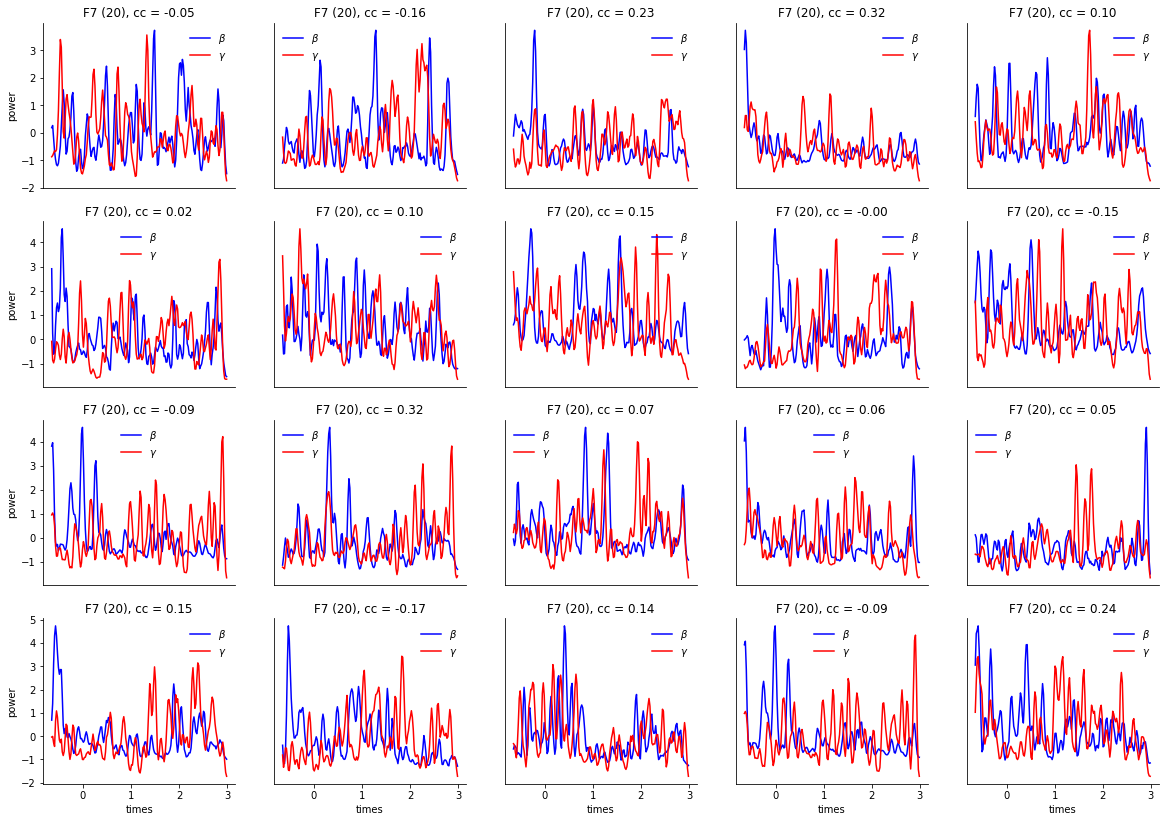

In [61]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "F7 (20)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

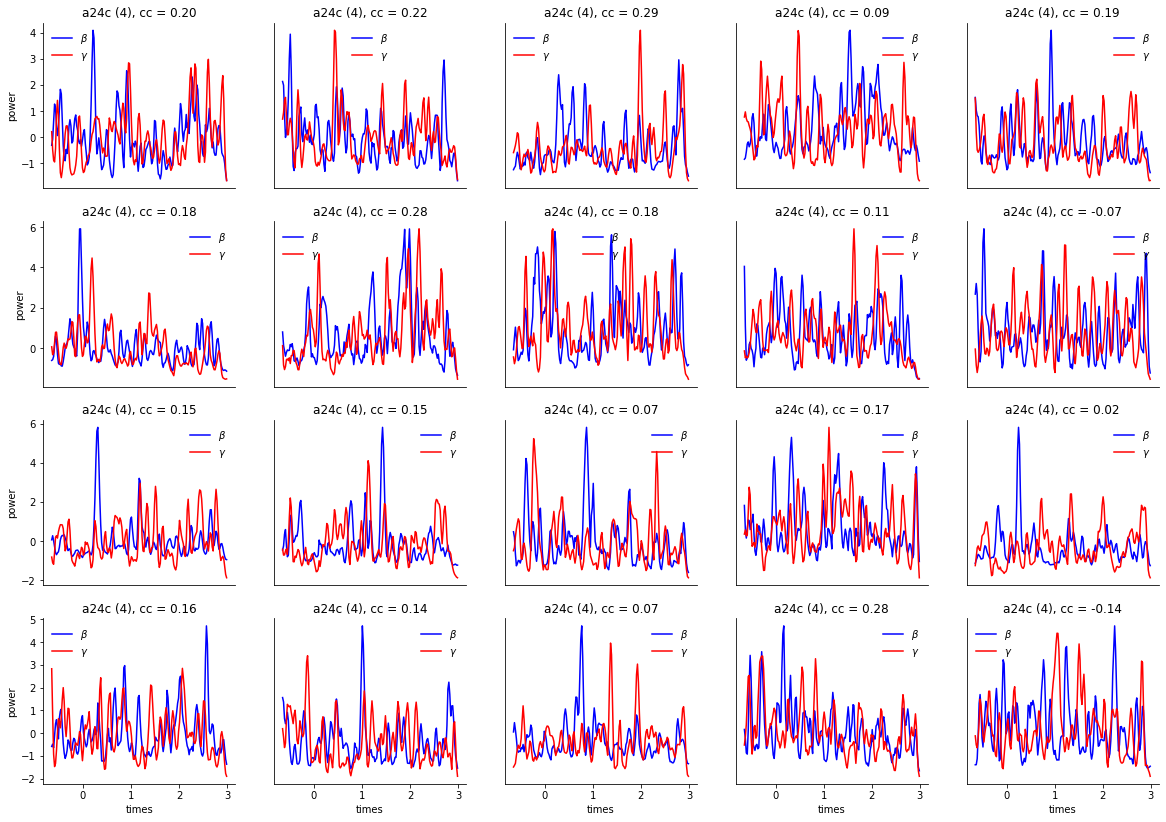

In [62]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "a24c (4)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

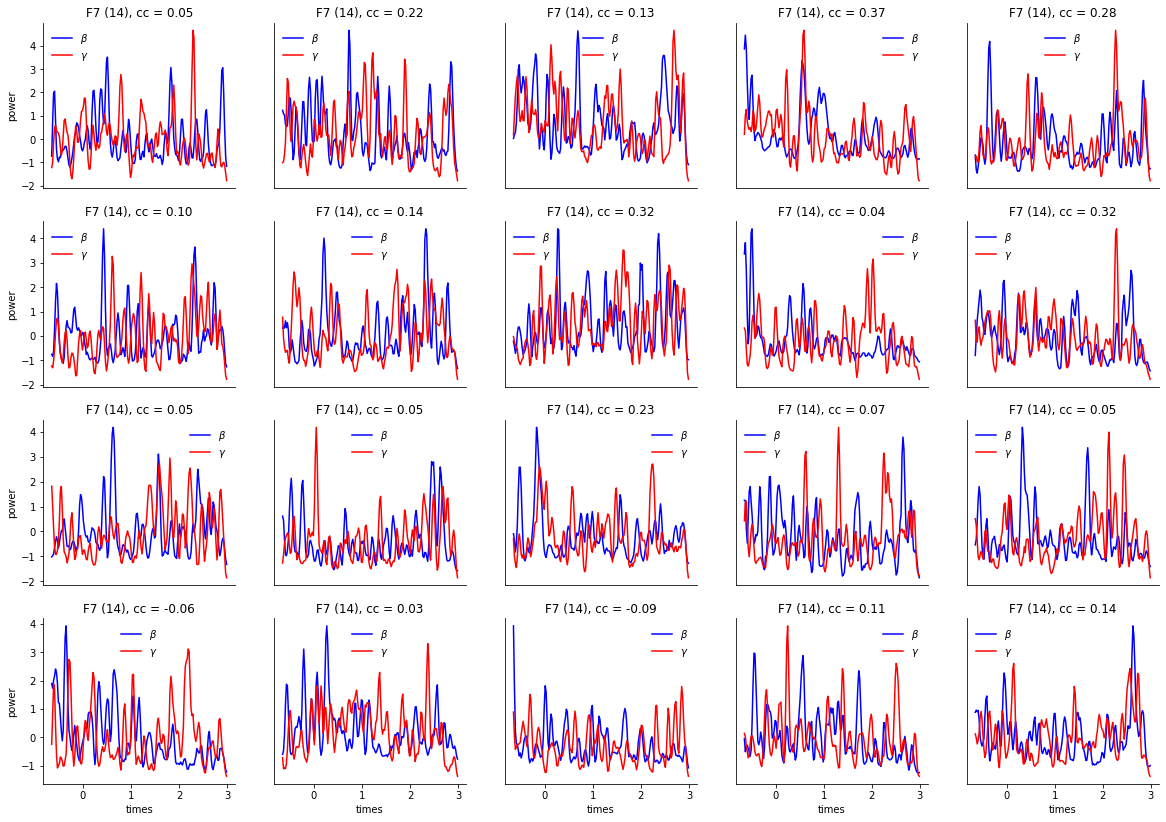

In [63]:
plt.figure(figsize=(20, 14))

t_idx = np.random.randint(0, cc.sizes["trials"], 20)

roi = "F7 (14)"

for i, t in enumerate(t_idx):
    ax = plt.subplot(4, 5, i + 1)
    z_beta.sel(roi=roi).isel(trials=t).plot(color="blue")
    z_gamma.sel(roi=roi).isel(trials=t).plot(color="r")
    plt.legend([r"$\beta$", r"$\gamma$"], frameon=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{roi}, cc = {cc.sel(roi=roi).isel(trials=t).data:.2f}")
    if i + 1 not in [1, 6, 11, 16]:
        plt.ylabel("")
        plt.yticks([])
    if i + 1 < 16:
        plt.xlabel("")
        plt.xticks([])

#### Phase-differences between beta and gamma bands

In [64]:
from mne.filter import filter_data

In [65]:
data_beta = filter_data(data, data.sfreq, 26, 43, method="iir", n_jobs=-1)
data_gamma = filter_data(data, data.sfreq, 43, 80, method="iir", n_jobs=-1)

data_beta = xr.DataArray(data_beta, dims=data.dims, coords=data.coords)
data_gamma = xr.DataArray(data_gamma, dims=data.dims, coords=data.coords)

Setting up band-pass filter from 26 - 43 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 26.00, 43.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    2.0s
[Parallel(n_jobs=40)]: Done 193 tasks      | elapsed:    2.2s
[Parallel(n_jobs=40)]: Done 1536 tasks      | elapsed:    2.8s
[Parallel(n_jobs=40)]: Done 16640 tasks      | elapsed:    6.8s
[Parallel(n_jobs=40)]: Done 40931 tasks      | elapsed:   12.0s
[Parallel(n_jobs=40)]: Done 43622 tasks      | elapsed:   13.0s
[Parallel(n_jobs=40)]: Done 45396 out of 45396 | elapsed:   13.6s finished


Setting up band-pass filter from 43 - 80 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 43.00, 80.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=40)]: Done 304 tasks      | elapsed:    0.3s
[Parallel(n_jobs=40)]: Done 2776 tasks      | elapsed:    1.2s
[Parallel(n_jobs=40)]: Done 7960 tasks      | elapsed:    2.6s
[Parallel(n_jobs=40)]: Done 14296 tasks      | elapsed:    4.3s
[Parallel(n_jobs=40)]: Done 21784 tasks      | elapsed:    6.1s
[Parallel(n_jobs=40)]: Done 30424 tasks      | elapsed:    8.4s
[Parallel(n_jobs=40)]: Done 40216 tasks      | elapsed:   11.2s
[Parallel(n_jobs=40)]: Done 44960 tasks      | elapsed:   12.7s
[Parallel(n_jobs=40)]: Done 45338 tasks      | elapsed:   13.5s
[Parallel(n_jobs=40)]: Done 45396 out of 45396 | elapsed:   13.6s finished


In [66]:
n_rois = data_beta.sizes["roi"]
sources = np.arange(n_rois)
targets = sources + n_rois

pairs = np.vstack((sources, targets)).T

x = xr.concat([data_beta[..., ::20], data_gamma[..., ::20]], "roi")

In [67]:
from frites.conn import conn_ccf

In [68]:
ccf = conn_ccf(x, times="time", roi="roi", n_jobs=-1, pairs=pairs)

Defining links (n_roi=156; directed=False; net=False, nb_min_links=None)
    Sorting roi names
Computing CCF between 78 pairs


  0%|          | Estimating CCF : 0/78 [00:00<?,       ?it/s]

In [69]:
lags = ccf["times"][ccf.argmax("times")]
lags = lags.to_dataframe("lags").reset_index()

In [70]:
del lags["trials"], lags["times"]

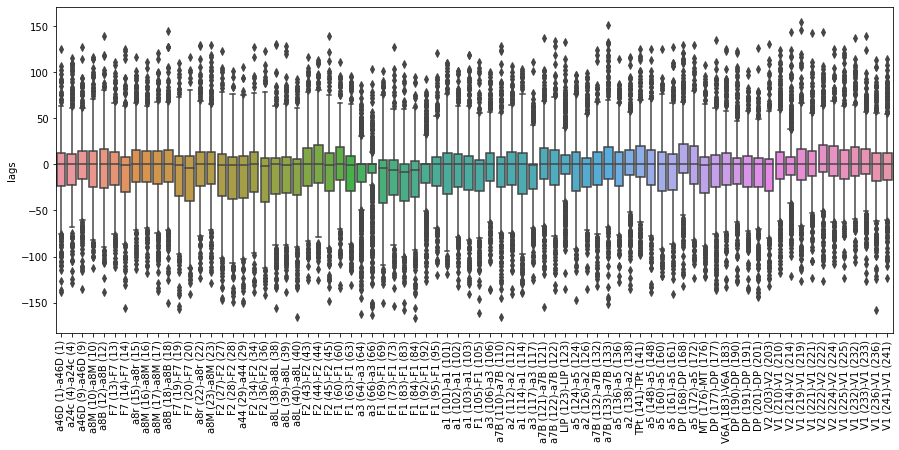

In [71]:
plt.figure(figsize=(15, 6))

sns.boxplot(x=lags["roi"], y=lags["lags"])
plt.xticks(rotation=90)
plt.xlabel("")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

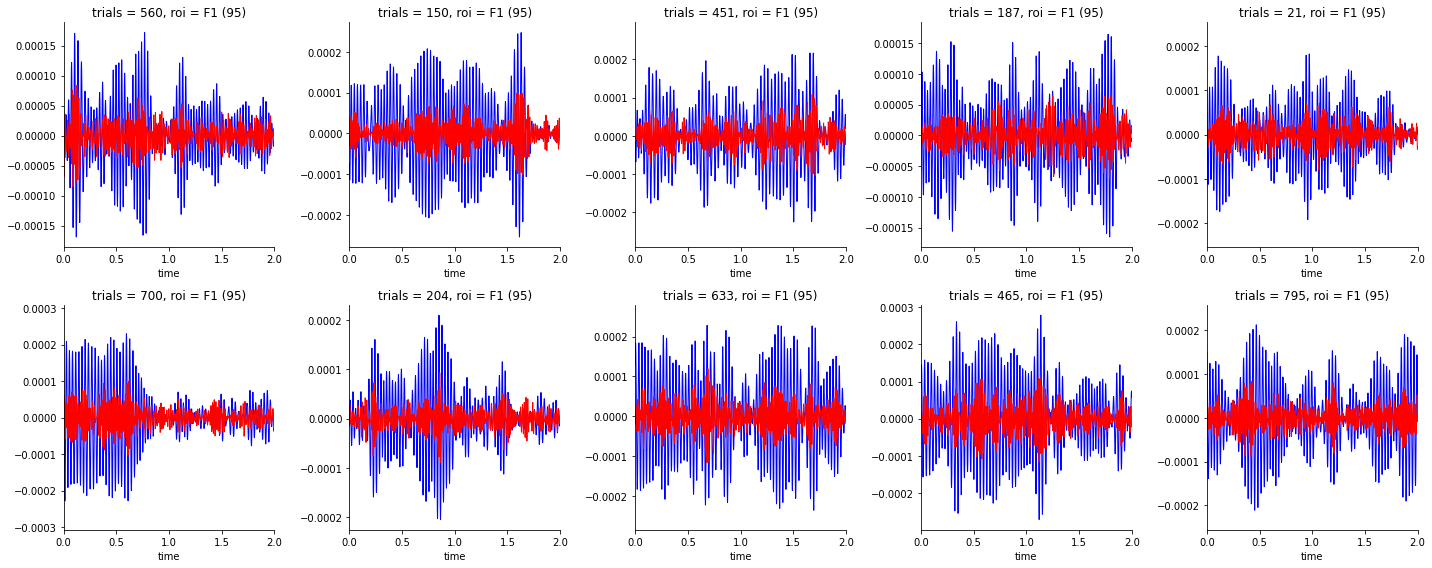

In [72]:
plt.figure(figsize=(20, 8))

t_idx = np.random.randint(0, cc.sizes["trials"], 10)

roi = "F1 (95)"

i = 1

for t in t_idx:

    ax = plt.subplot(2, 5, i)

    data_beta.sel(roi=roi).isel(trials=t).plot(x="time", color="b", lw=1)
    data_gamma.sel(roi=roi).isel(trials=t).plot(x="time", color="r", lw=1)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xlim([0, 2])

    i = i + 1
plt.tight_layout()

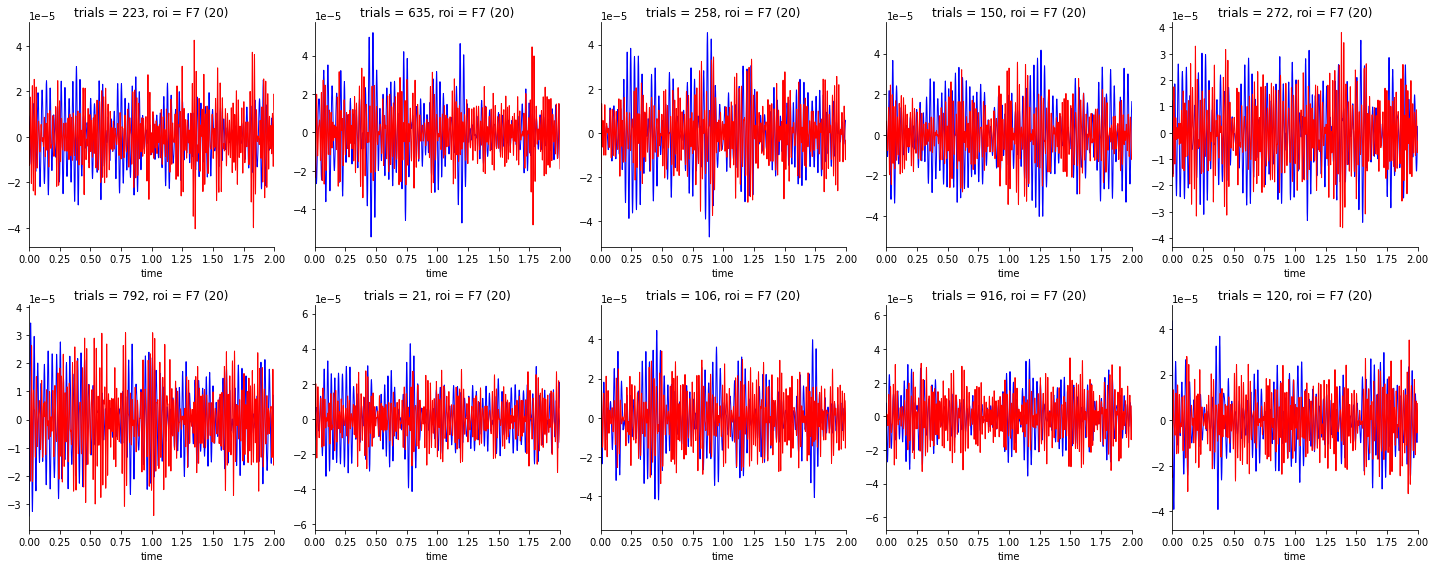

In [73]:
plt.figure(figsize=(20, 8))

t_idx = np.random.randint(0, cc.sizes["trials"], 10)

roi = "F7 (20)"

i = 1

for t in t_idx:

    ax = plt.subplot(2, 5, i)

    data_beta.sel(roi=roi).isel(trials=t).plot(x="time", color="b", lw=1)
    data_gamma.sel(roi=roi).isel(trials=t).plot(x="time", color="r", lw=1)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xlim([0, 2])

    i = i + 1
plt.tight_layout()

### FOOOF

In [74]:
from fooof import FOOOF, FOOOFGroup
from fooof.analysis import get_band_peak_fg, get_band_peak_fm
from fooof.bands import Bands

In [75]:
out = w.sel(roi="V1 (236)", times=slice(-0.5, 0)).mean("times")

In [76]:
freqs = out.freqs.data
freq_range = [freqs[0], freqs[-1]]
spectrum = out.isel(trials=10).data


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 75 Hz                        
                                 Frequency Resolution is 0.91 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

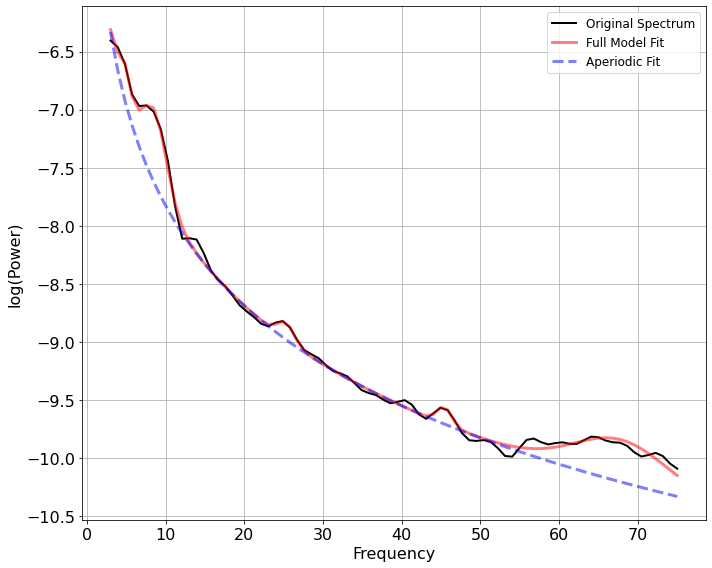

In [77]:
fm = FOOOF()
fm.report(freqs, spectrum, freq_range)

In [78]:
# Define frequency bands of interest
bands = Bands({"beta": [26, 43]})

In [79]:
n_spectra = out.sizes["trials"]
freqs = out.freqs.data
freq_range = [freqs[0], freqs[-1]]
spectra = out.data

In [80]:
fg = FOOOFGroup()
fg.fit(freqs, spectra)

Running FOOOFGroup across 582 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



In [119]:
def find_peaks(data=None, roi=None, freqs=None, trials=None, band=None):
    # Get number of trials
    n_spectra = data.sizes[trials]
    # Get frequencies
    freqs = data[freqs].data
    freq_range = [freqs[0], freqs[-1]]
    spectra = data.sel(roi=roi).data
    # Create FOOOF group
    fg = FOOOFGroup(verbose=False)
    fg.fit(freqs, spectra, n_jobs=-1)
    peaks = get_band_peak_fg(fg, band)[:, 0]
    return peaks > 0

In [82]:
df = w.sel(times=slice(-0.5, 0)).mean("times")

P = np.zeros((data.sizes["roi"], data.sizes["trials"]))

i = 0
for roi in tqdm(df.roi.data):
    P[i, :] = find_peaks(df, roi=roi, freqs="freqs", trials="trials", band=[26, 43])
    i = i + 1

100%|████████████████████████████| 78/78 [04:20<00:00,  3.34s/it]


In [83]:
P = xr.DataArray(
    P, dims=("roi", "trials"), coords={"roi": data.roi.data, "trials": data.trials.data}
)

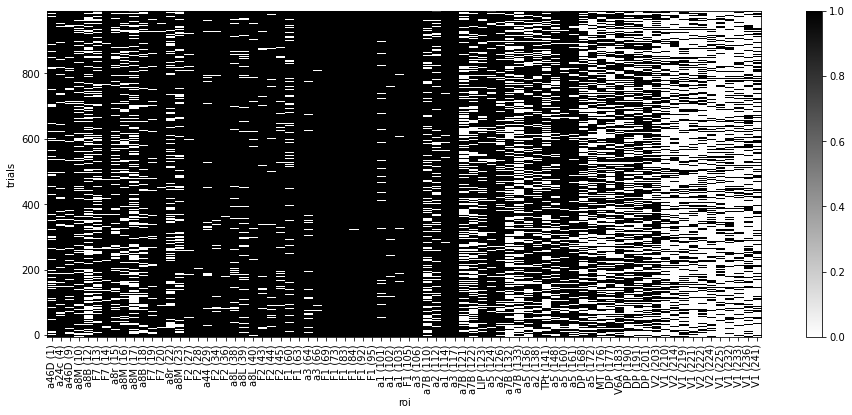

In [84]:
plt.figure(figsize=(16, 6))
P.plot.imshow(x="roi", y="trials", cmap="binary")
plt.xticks(rotation=90);

In [140]:
o = p_coh_band.isel(roi=6).isel(freqs=3) * (P.sel(roi='F1 (84)') + P.sel(roi='V1 (236)')) + p_coh_band.isel(roi=6).isel(freqs=3)

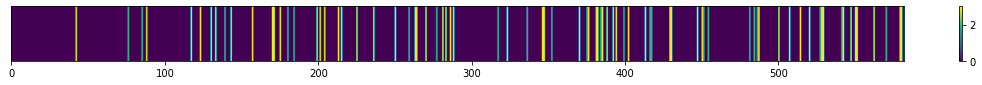

In [164]:
plt.figure(figsize=(20, 1))
plt.imshow(o.data[None, :], aspect="auto", cmap="viridis")
plt.yticks([])
plt.colorbar()

In [169]:
np.sum(o==3)

<xarray.DataArray ()>
array(57)
Coordinates:
    roi       <U17 'F1 (84)-V1 (236)'
    quantile  float64 0.95

In [170]:
27/(27+53)

0.3375